In [1]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
%matplotlib inline


model shape = (250, 200, 100)


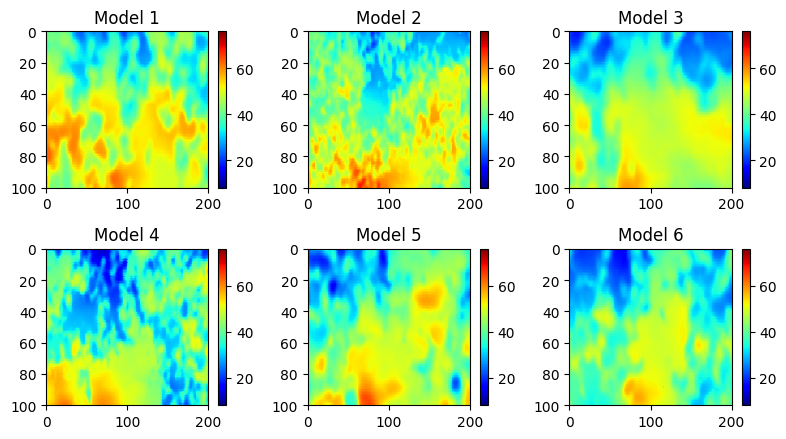

In [24]:
path = Path('input/prior_samples/thickness.npy')
prior_model = np.load(path)

grid_dim = (200, 100)
nsamples = 250
prior_model = np.array(prior_model.reshape((nsamples, *grid_dim), order='F'))
print(f'model shape = {prior_model.shape}')

vmax = round(np.max(prior_model))
vmin = round(np.min(prior_model))

fig = plt.figure(figsize=(8, 4.5))
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    x = prior_model.view()[i, :, :].transpose()
    img = ax.pcolor(x, cmap='jet', vmin=vmin, vmax=vmax)
    ax.set_title(f'Model {i + 1}')
    ax.invert_yaxis()
    fig.colorbar(img, ax=ax)
fig.tight_layout()

In [25]:
path = Path('input/thickness_obs')
d = np.loadtxt(path, skiprows=1)
iloc = d[:,:2].astype(int) - 1
# Flip j index
iloc[:, 1] = grid_dim[1] - iloc[:, 1] - 1
obs_data = d[:,3]

prior_data = np.zeros((nsamples, obs_data.size))
for i in range(nsamples):
    prior_data[i,:] = prior_model.view()[i, iloc[:,0], iloc[:,1]].reshape((obs_data.size))

In [4]:
# Calculate GIIP
dx = 250.0
dy = 250.0
area = dx*dy

thickness = prior_model
bulk_volume = thickness*area
porosity = 1.0
gas_saturation = 1.0
formation_volume_factor = 0.6767

vb = bulk_volume
phi = porosity
sg = gas_saturation
fvf = formation_volume_factor
gas_initially_in_place = (vb*phi*sg).sum(axis=1)/fvf

In [35]:
import pandas as pd

x = pd.DataFrame(prior_model.view().reshape((nsamples, -1)))
# Scaling
x = (x - x.mean())/x.std()

# PCA
pca = PCA()
pca.fit(x)

scores = pca.transform(x)
loadings = pca.components_

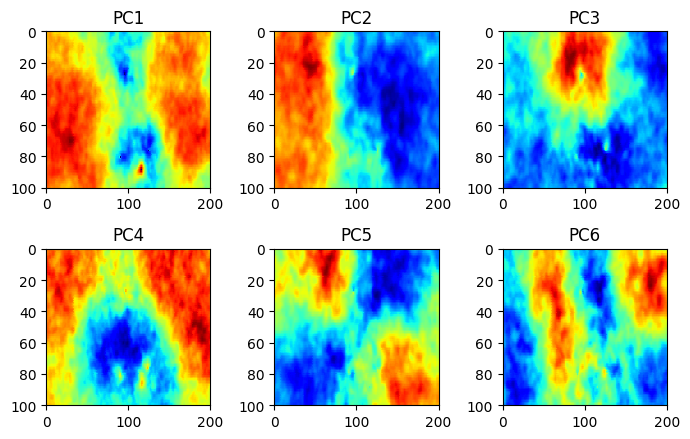

In [39]:
# Plot eigen vectors
fig = plt.figure(figsize=(7, 4.5))
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    y = loadings[i, :].view().reshape(grid_dim).transpose()
    img = ax.pcolor(y, cmap='jet')
    ax.set_title(f'PC{i + 1}')
    ax.invert_yaxis()
fig.tight_layout()
plt.show()

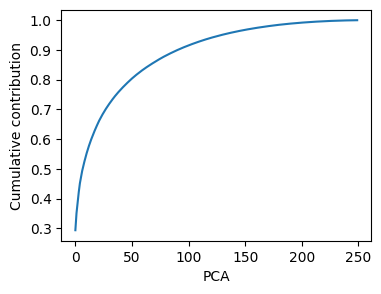

In [38]:
# Plot contribution
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(pca.explained_variance_ratio_.cumsum())
ax.set_xlabel('PCA')
ax.set_ylabel('Cumulative contribution')
plt.show()

95th quantile of robust Mahalanobis distance = 23.63


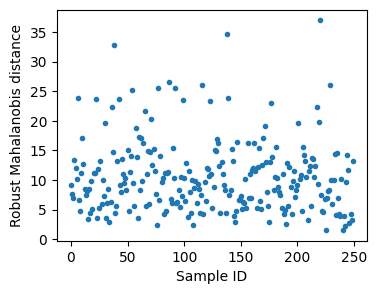

In [46]:
from sklearn.covariance import MinCovDet
from scipy.stats import scoreatpercentile

y = pd.DataFrame(prior_data)
# Scaling
y = (y - y.mean())/y.std()

cov = MinCovDet(random_state=0).fit(y)
dist = cov.mahalanobis(y)
dist_95 = scoreatpercentile(dist, per=95)
print(f'95th quantile of Mahalanobis distance = {dist_95:.2f}')

fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(111)
ax.plot(dist, linewidth=0, marker='o', markersize=3)
ax.set_xlabel('Sample ID')
ax.set_ylabel('Mahalanobis distance')
plt.show()

In [12]:
from sklearn_extra.cluster import KMedoids

kmedoids = KMedoids(n_clusters=3, random_state=0).fit(scores)
